In [4]:
import torch
from feature_extractors import feature_extractor
import sys

In [5]:
sys.modules["bow.feature_extractor"] = feature_extractor

In [6]:
ckp = torch.load("ckpts/cnn.ckpt", map_location="cpu")

In [7]:
from protoclr_obow import PCLROBoW

In [8]:
from omegaconf import OmegaConf
OmegaConf.register_new_resolver("uuid", lambda : "123")

In [9]:
model = PCLROBoW.load_from_checkpoint("ckpts/cnn.ckpt")

MultiHeadDotProduct


/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [10]:
from dataloaders import UnlabelledDataset, UnlabelledDataModule

In [11]:
dm = UnlabelledDataModule(**OmegaConf.load("configs/local/edge.yml")["data"], split="train")
dm.setup()

In [12]:
dlt = dm.train_dataloader()

In [13]:
xs = next(iter(dlt))

In [14]:
o,v = xs["origs"], xs["views"]

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import einops
sns.set_theme()

In [16]:
o = einops.rearrange(o, "b 1 c h w -> b c h w")

In [17]:
v = einops.rearrange(v, "b q c h w -> (b q) c h w")

In [19]:
y_query = torch.arange(64).unsqueeze(
            0).unsqueeze(2)  # batch and shot dim
y_query = y_query.repeat(1, 1, 3)
y_query = y_query.view(1, -1)

y_support = torch.arange(64).unsqueeze(
    0).unsqueeze(2)  # batch and shot dim
y_support = y_support.repeat(1, 1, 1)
y_support = y_support.view(1, -1)

In [20]:
y = torch.cat([y_support, y_query], dim=1).squeeze(0)

In [21]:
feats = model.feature_extractor(torch.cat([o, v]))

In [22]:
feats = feats.flatten(1)

In [23]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

<AxesSubplot:>

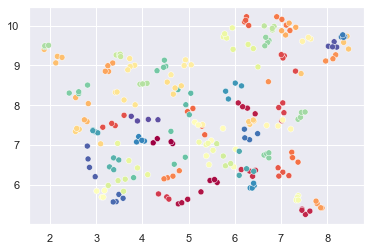

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)

In [25]:
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)

In [26]:
feats = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

In [27]:
gfeats = umap.UMAP().fit_transform(feats[1][0].cpu().detach().numpy())

<AxesSubplot:>

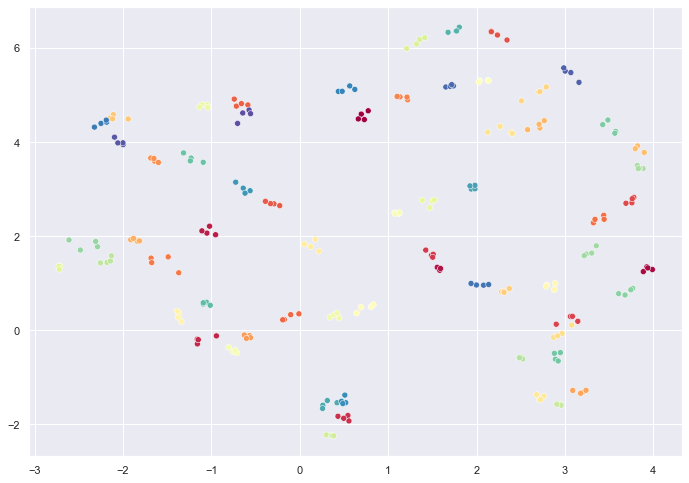

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=gfeats[:, 0], y=gfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)